# Introduction

In this assignment you will practice calibrating a camera, computing homography between images and stitching panoramas. The goals of this assignment are as follows:



*   Understand the intrinsic parameters of a prospective camera.
*   Understand feature detection and feature matching process.
*   Find the intrinsic and extrinsic parameters of a camera using ChArUco patterns.
*   Compute homography between two images.
*   Use homography to stitch panoramas.

Please fill in all the **TODO** blocks (including codes and texts). Most of the assignment can be done by calling functions in OpenCV. Once you are ready to submit:

* Export the notebook `CSCI677_spring25_assignment_1.ipynb` as a PDF `[Your USC ID]_CSCI677_spring25_assignment_1.pdf` and submit the PDF

Please make sure that the notebook have been run before exporting PDF, and your code and all cell outputs are visible in your submitted PDF. Regrading request will not be accepted if your code/output is not visible in the original submission. Thank you!

# Calibration (35 pts)


## Data Collection (5 points)

To determine the intrinsic parameters of a camera, you will need to capture sample images of an [ChArUco board](https://docs.opencv.org/4.x/db/da9/tutorial_aruco_board_detection.html). These images are obtained by photographing printed ChArUco patterns displayed on a flat surface or screen.

### Steps:
1. Use the provided sample code to generate your own ChArUco pattern. Feel free to adjust the function parameters.
2. Print the generated pattern or display it on a flat screen.
3. Capture at least **10 photos** of the ChArUco board from **different angles** to ensure accuracy in calibration.
4. Make sure that **each photo covers the entire ChArUco board** for proper detection.

These images will be used later for camera calibration.

ChArUco board saved at: ./charuco_boards/charuco_4_7x5_1.0_0.8.tiff


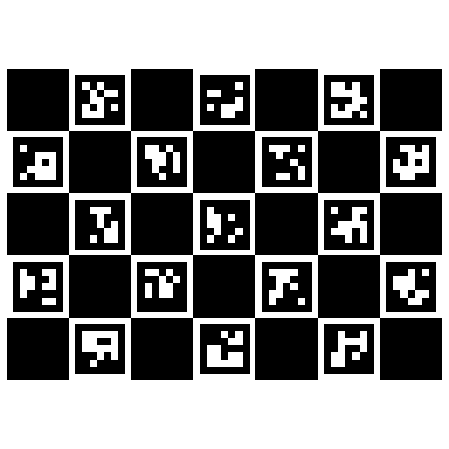

In [167]:
import numpy as np
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import os

def generate_charuco_board(
    save_dir: str, 
    squares_x: int = 7, 
    squares_y: int = 5, 
    square_length: float = 1.0, 
    marker_length: float = 0.8, 
    aruco_dict_type: int = aruco.DICT_5X5_50, 
    image_size: tuple = (2000, 2000),
    plot_results: bool = False
) -> tuple:
    """
    Generates and saves a ChArUco board image.
    
    Args:
        save_dir (str): Directory to save the generated ChArUco board image.
        squares_x (int): Number of squares along the horizontal direction.
        squares_y (int): Number of squares along the vertical direction.
        square_length (float): Side length of each square (in arbitrary units).
        marker_length (float): Side length of each marker (in arbitrary units).
        aruco_dict_type (int): Type of the ArUco dictionary to use.
        image_size (tuple): Size of the output image (width, height).
        plot_results (bool): Whether to display the generated board.
    
    Returns:
        tuple: The ArUco dictionary and ChArUco board object.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Create the ArUco dictionary
    aruco_dict = aruco.Dictionary_get(aruco_dict_type)
    
    # Create the ChArUco board
    board = aruco.CharucoBoard_create(
        squares_x, squares_y, square_length, marker_length, aruco_dict
    )
    
    # Generate the board image
    board_image = board.draw(image_size)
    
    # Save the image with a unique name
    filename = f"charuco_{aruco_dict_type}_{squares_x}x{squares_y}_{square_length}_{marker_length}.tiff"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, board_image)
    print(f"ChArUco board saved at: {filepath}")
    
    # Optionally plot the board
    if plot_results:
        plt.figure(figsize=(8, 8))
        plt.imshow(board_image, cmap='gray', interpolation="nearest")
        plt.axis("off")
        plt.show()
    
    return aruco_dict, board

# Example usage
save_directory = "./charuco_boards/"
aruco_dict, charuco_board = generate_charuco_board(
    save_dir=save_directory, 
    plot_results=True
)

In [258]:
# load images
image_dir = "./images"
images = []
for i, filename in enumerate(os.listdir(image_dir)):
    fp = os.path.join(image_dir, filename)
    img = cv2.imread(fp)
    img = cv2.resize(img, (2000, 2000))
    images.append(img)
# images = [charuco_board.draw((2000, 2000))]
print(images[0].shape)

(2000, 2000, 3)


## Calibration (15 pts)
To calibrate the camera, you will need to detect the ChArUco markers in the photos you captured during the data collection step. The following [tutorial]((https://docs.opencv.org/3.4/da/d13/tutorial_aruco_calibration.html)) may be helpful.

### Steps:
1. Detect markers: Use the `cv2.aruco.detectMarkers()` function to locate the ArUco markers in each image.
2. Calibrate the Camera: Use the `cv2.aruco.calibrateCameraCharuco()` function to calculate the intrinsic camera parameters. Provide the detected ChArUco corners, corresponding IDs, board configuration, and image dimensions. You may find the following [tutorial](https://docs.opencv.org/3.4/da/d13/tutorial_aruco_calibration.html) helpful.
3. Output the Intrinsic Parameters: Print the ***camera matrix*** and ***distortion coefficients*** after the calibration process.

In [259]:
aruco_params = cv2.aruco.DetectorParameters_create()
aruco_params.adaptiveThreshConstant = 7
aruco_params.minMarkerPerimeterRate = 0.03 
aruco_params.maxMarkerPerimeterRate = 4.0
all_corners, all_ids = [], []
for image in images:
    (corners, ids, rejected) = cv2.aruco.detectMarkers(image, dictionary=aruco_dict)
    res, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(corners, ids, image, charuco_board)
    all_corners.append(charuco_corners)
    all_ids.append(charuco_ids)

calibration, camera_matrix, dist_coeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(charucoCorners=all_corners, charucoIds=all_ids, board=charuco_board, imageSize=(2000, 2000), cameraMatrix=None, distCoeffs=None)
    

In [238]:
print(calibration)

0.3861664566450649


## Pose Estimation (10 pts)

Once you have obtained the camera parameters, use them to calculate the pose of the Charuco board. To validate your code, render the axes on 3 of your Charuco board images. You can refer to the following [tutorial](https://docs.opencv.org/3.4/df/d4a/tutorial_charuco_detection.html) for guidance on pose estimation and rendering the axes.

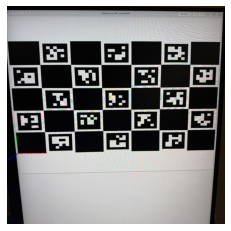

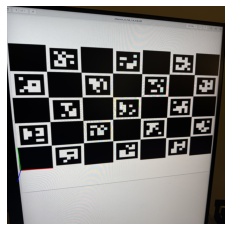

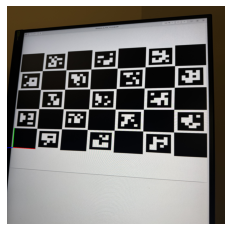

In [264]:
for i, image in enumerate(images[:3]):
    image_copy = image.copy()
    retval, rvec, tvec = aruco.estimatePoseCharucoBoard(all_corners[i], all_ids[i], charuco_board, camera_matrix, dist_coeffs)
    aruco.drawAxis(image_copy, camera_matrix, dist_coeffs, rvec, tvec, 1)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

## Observation (5 pts)
Write down your observations regarding the results you obtained throughout the `Calibration` section.

The detectMarkers function finds 16 to 17 markers in each image, which is close to the actual number of markers (17) in the charuco board, but occasionally misses 1 of the markers in some of the images. Looking at the visualized axes on the 3 reference images above, it seems that camera calibration was successul and the estimated pose aligns with what the actual pose of the charuco board pictures are. 

# Homography (35 pts)

## Data Preparation

Please download the `data.zip` file from the [link](https://drive.google.com/file/d/1Q3NyoeDbKwnp6JeV91gxJkE6m_sMWRmV/view?usp=sharing), and extract it to a location of your choice. For this part of the assignment, use the images in the `homography` folder. 

## Feature Detection (10 pts)

After you have the two photos, load them using `cv.imread()`. Convert them to grayscale images. Create a SURF feature detector and detect keypoints on all images. Display the keypoints with size and orientation. For image display (only), adjust the Hessian threshold to show fewer than 30 features.

You can follow the tutorial [here](https://docs.opencv.org/4.8.0/df/dd2/tutorial_py_surf_intro.html) to understand the implementation and use of SURF.

In [153]:
def plot_image_gray(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray', interpolation="nearest")
    plt.axis("off")
    plt.show()

22 746


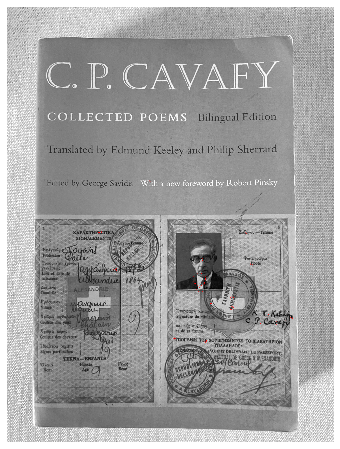

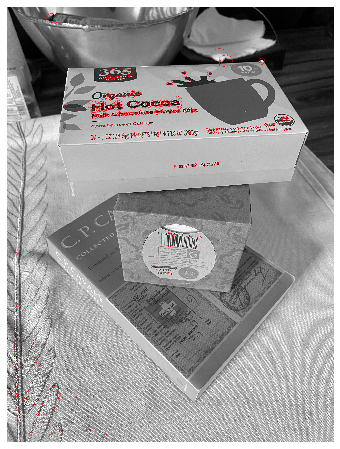

In [111]:
img_dir = './data/homography/'
src0_path = os.path.join(img_dir, 'src_0.jpg')
dst0_path = os.path.join(img_dir, 'dst_0.jpg')
src0 = cv2.imread(src0_path, cv2.IMREAD_GRAYSCALE)
dst0 = cv2.imread(dst0_path, cv2.IMREAD_GRAYSCALE)
surf = cv2.xfeatures2d.SURF_create(17_000)
kp_src0, des_src0 = surf.detectAndCompute(src0, None)
kp_dst0, des_dst0 = surf.detectAndCompute(dst0, None)
print(len(kp_src0), len(kp_dst0))
src0_2 = cv2.drawKeypoints(src0, kp_src0, None, (255, 0, 0), 4)
dst0_2 = cv2.drawKeypoints(dst0, kp_dst0, None, (255, 0, 0), 4)
plot_image_gray(src0_2)
plot_image_gray(dst0_2)

## Feature Matching (10 pts)

Create a FLANN based matcher. Find matches among the descriptors you just detected between every pairs of src-dst images. Graphically show the top-20 matches found by the matcher (for each src-dst pair). You can follow the tutorial in https://docs.opencv.org/4.5.2/dc/dc3/tutorial_py_matcher.html

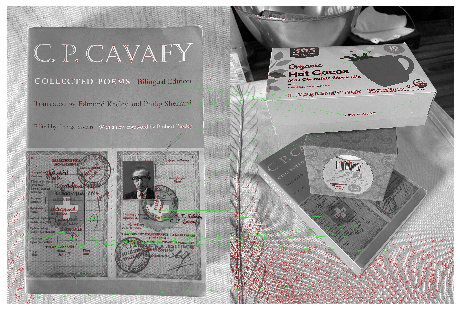

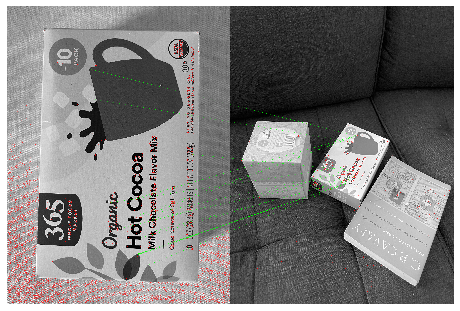

In [112]:
def match_and_plot(src_img, dst_img):
    # SURF
    surf = cv2.xfeatures2d.SURF_create(5000)
    kp_src, des_src = surf.detectAndCompute(src_img, None)
    kp_dst, des_dst = surf.detectAndCompute(dst_img, None)
    
    # FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    flann = cv2.FlannBasedMatcher(index_params)
    matches = flann.knnMatch(des_src, des_dst, k=2)
    top20_matches = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            top20_matches.append([m])
    top20_matches = sorted(top20_matches, key=lambda x: x[0].distance)[:20]
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
    matches_img = cv2.drawMatchesKnn(src_img, kp_src, dst_img, kp_dst, top20_matches, None, **draw_params)
    plot_image_gray(matches_img)
    
match_and_plot(src0, dst0)

src1_path = os.path.join(img_dir, 'src_1.jpg')
dst1_path = os.path.join(img_dir, 'dst_1.jpg')
src1 = cv2.imread(src1_path, cv2.IMREAD_GRAYSCALE)
dst1 = cv2.imread(dst1_path, cv2.IMREAD_GRAYSCALE)
match_and_plot(src1, dst1)

## Compute Homography (10 pts)

Compute the homography using RANSAC. Print out the homography matrix. Transform the four corners of the source image using the homography and display the transformed rectangle on the destination image. You can follow the tutorial in https://docs.opencv.org/4.5.2/d1/de0/tutorial_py_feature_homography.html

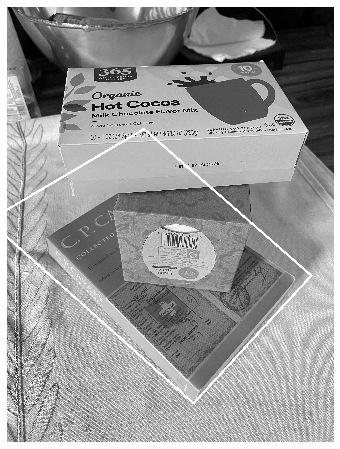

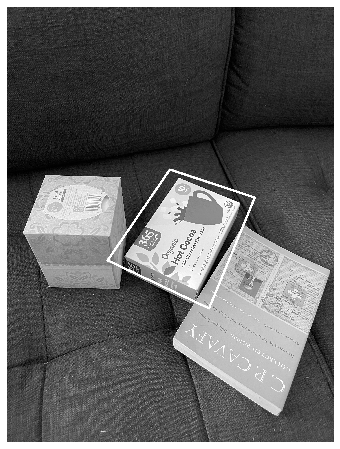

In [113]:
def compute_homography(src_img, dst_img):
        # SURF
    surf = cv2.xfeatures2d.SURF_create(5000)
    kp_src, des_src = surf.detectAndCompute(src_img, None)
    kp_dst, des_dst = surf.detectAndCompute(dst_img, None)
    
    # FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    flann = cv2.FlannBasedMatcher(index_params)
    matches = flann.knnMatch(des_src, des_dst, k=2)
    top20_matches = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            top20_matches.append(m)
    top20_matches = sorted(top20_matches, key=lambda x: x.distance)[:20]
    src_pts = np.float32([kp_src[m.queryIdx].pt for m in top20_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_dst[m.trainIdx].pt for m in top20_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()
    h, w = src_img.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    draw_img = cv2.polylines(dst_img, [np.int32(dst)], True, 255, 20, cv2.LINE_AA)
    plot_image_gray(draw_img)

compute_homography(src0, dst0)
compute_homography(src1, dst1)


## Observation (5 pts)
Write down your observations regarding the results you obtained throughout the `Homography` section.

The algorithm is capable of finding roughly the correct transformation and bounding box that corresponds to the object and it's orientation in the destination image. It also seems to handle partial occlusions decently well, as seen in the first image pair. However, there are slight errors in the bounding box rotation and shear. I believe that tuning the hyperparameters e.g. the SURF threshold value, the number of good matches to use etc. could make the algorithm work better.

# Panorama (30 pts)

## Data Preparation

Please download the `data.zip` file from the [link](https://drive.google.com/file/d/1Q3NyoeDbKwnp6JeV91gxJkE6m_sMWRmV/view?usp=sharing), and extract it to a location of your choice. For this part of the assignment, use the images in the `panorama` folder. 

## Compute Homography (10 pts)
Here we are computing homography again, but once every two consecutive images. To do this, you need to first import the images. Then you pick a feature detector (not necessarily SIFT) and detect features. Then you pick a feature matcher (not necessarily brute-force) and find matches between every two consecutive images. Then you compute homography and store them. Below we write a skeleton for you, but you needn't follow it.

In [162]:
import numpy as np
import cv2 as cv
import os

def compute_homography(src_img, dst_img):
        # SURF
    surf = cv2.xfeatures2d.SURF_create(5000)
    kp_src, des_src = surf.detectAndCompute(src_img, None)
    kp_dst, des_dst = surf.detectAndCompute(dst_img, None)
    
    # FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_src, des_dst, k=2)
    topk_matches = []
    k = 100
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            topk_matches.append(m)
    topk_matches = sorted(topk_matches, key=lambda x: x.distance)[:k]
        
    src_pts = np.float32([kp_src[m.queryIdx].pt for m in topk_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_dst[m.trainIdx].pt for m in topk_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M

# read images
input_path = 'data/panorama/'
filenames = [input_path + filename for filename in os.listdir(input_path)]
images = [cv.imread(filename) for filename in filenames]
count = len(images)

homography_matrices = []
for i in range(count-1):
    # convert to grayscale images
    gray1 = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(images[i+1], cv.COLOR_BGR2GRAY)

    M = compute_homography(gray1, gray2)
    homography_matrices.append(M)

## Stitch Panorama (15 pts)
Now we can stitch those images to compose a panorama. You need to select an image as an anchor and transform other images onto this anchor image. The transformation between any image and this anchor image is the composition of a series of homography. You should compute the transformations and map all other images onto the anchor image. You can explore other ways to define an anchor. Then you need to blend these image. A possible way is to just take the maximum of the pixel values, but you are encouraged to explore other blending methods (extra points +2~5 pts). After you obtained your panorama, display it along with some intermediate results including feature matches and transformed images. We attached an example in the folder `panorama_output`. Below we provide the code to compute the size of a rectangle that covers all transformed images, but you needn't follow it.

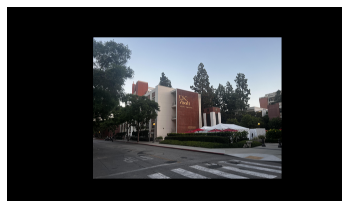

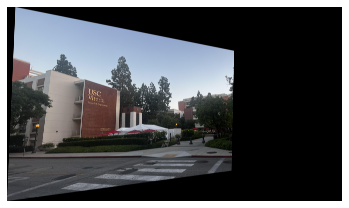

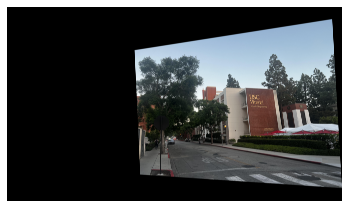

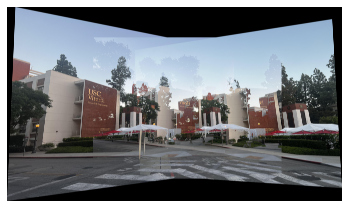

In [166]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

def plot_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# use 1st image as anchor. Compute homographies wrt first image
cum_homographies = [np.eye(3)]
for i in range(count - 1): 
    H = cum_homographies[-1] @ homography_matrices[i]
    H_normalized = H / H[2, 2]
    cum_homographies.append(H_normalized)
    
min_x = min_y = max_x = max_y = 0.0
for i in range(count):
    # Get the height and width of the original images
    h, w, p = images[i].shape
    # Create a list of points to represent the corners of the images
    corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
    # Calculate the transformed corners
    transformed_corners = cv.perspectiveTransform(corners.reshape(-1, 1, 2), cum_homographies[i])
    # Find the minimum and maximum coordinates to determine the output size
    min_x = min(transformed_corners[:, 0, 0].min(), min_x)
    min_y = min(transformed_corners[:, 0, 1].min(), min_y)
    max_x = max(transformed_corners[:, 0, 0].max(), max_x)
    max_y = max(transformed_corners[:, 0, 1].max(), max_y)

# Calculate the width and height of the stitched image
output_width = int(max_x - min_x)
output_height = int(max_y - min_y)
translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

panorama = np.zeros((output_height, output_width, 3), dtype=np.uint8)
for img, H in zip(images, cum_homographies):
    warped_img = cv2.warpPerspective(img, translation @ H, (output_width, output_height))
    plot_image(warped_img)
    
    panorama = np.maximum(panorama, warped_img)
    
plot_image(panorama)
# TODO: blend the transformed images

# TODO: display the panorama along with some intermediate results

## Observation (5 pts)
Write down your observations regarding the results you obtained throughout the `Panorama` section.

## **TODO: write down your observations**